In [1]:
import sys
sys.path.append('../utils/')

from query import query_dataframe_f, pprint_query, nbprint_and_query
use_latex = False

# Question 2

In [2]:
q2_data = nbprint_and_query('Q2_atm.sql')
q2_data.to_csv('q2_data.csv')

In [3]:
import pandas as pd
from datetime import datetime, timedelta

from trading_days import TradingDay

# Code run before this to retrieve data:
#q2a_data = nbprint_and_query('Q2a.sql')
#q2a_data.to_csv('q2a_data.csv')

q2_data = pd.read_csv('q2_data.csv',
                      parse_dates=['Date', 'Expiration'],
                      index_col=0)
q2_data['AdjStrike'] = q2_data['Strike'] / 1000.
# Expirations in IVY are on Saturdays, we need to compensate to the most recent trading day.
q2_data['ActualExpiration'] = q2_data['Expiration'] - TradingDay(1)

/usr/lib/python3/dist-packages/pandas/tseries/index.py:755: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning)


In [4]:
from datetime import datetime, timedelta
from itertools import chain
# Now, we've actually retrieved too much data.
# We first want to filter down to things that are actually +/- 10 trading days
# of an expiration. First, get all trading days, then build out all possible
# days, then filter where date is in that list of possible days.
def flatmap(f, items):
    return list(chain.from_iterable(map(f, items)))

def trading_window(date):
    return [TradingDay(n) + date
            for n in range(-11, 11)]

trading_days = flatmap(trading_window, q2_data['ActualExpiration'].unique())

q2_valid_data = q2_data[q2_data['Date'].isin(trading_days)]
q2_valid_data.head()

,Ticker,ClosePrice,Volume,Date,Strike,OpenInterest,Expiration,ImpliedVolatility,StrikeDiff,AdjStrike,ActualExpiration
0,SEE,25.459999,871972,2008-05-15,22500,64,2008-05-17,0.414089,2.959999,22.5,2008-05-16
1,MCHP,35.700001,1406783,2007-04-04,40000,133948,2007-04-21,0.266574,4.299999,40.0,2007-04-20
2,LIFE,42.880001,894862,2008-08-28,42500,281472,2008-08-16,0.368145,0.380001,42.5,2008-08-15
3,USB,35.580002,5307900,2007-03-20,37500,837242,2007-03-17,0.128736,1.919998,37.5,2007-03-16
4,FHN,10.950000,3299048,2008-08-28,15000,170476,2008-08-16,0.676179,4.050000,15.0,2008-08-15


In [5]:
# Now comes the fun part. Currently we have all strikes,
# and we essentially want to filter this down to only ATM strikes.
def filter_atm(group):
    return group.sort_values(by='StrikeDiff').head(1)

q2_groups = q2_valid_data.groupby(['Date', 'Ticker'])
q2_atm = q2_groups.apply(filter_atm)

q2_atm.reset_index(drop=True, inplace=True)

In [6]:
# Now we need to build out the 'score' we will be binning on.
# The 'score' is defined as Open Interest / Avg. daily volume for
# the five days before expiration.
# The way we go about doing this is to first calculate for each row
# how many business days there are before expiration. We will re-use
# this data later in actually building the chart. Once this is done,
# we can define the score column in a vectorized form, which will make
# it much faster to calculate relative to the filtering we've done so far.
def bus_days_between(start, end):
    if start.date() == end.date():
        return 0
    elif start < end:
        return len(pd.date_range(start=start.date(),
                                 end=end.date(),
                                 closed='left',
                                 freq=TradingDay(1)))
    else:
        return -len(pd.date_range(start=end.date(),
                                  end=start.date(),
                                  closed='left',
                                  freq=TradingDay(1)))
    
q2_atm['DeltaExpiration'] = q2_atm.apply(
    lambda r: bus_days_between(r.Date, r.ActualExpiration),
    1)

In [7]:
import numpy as np

def score(group):
    group['Score'] = group['OpenInterest'] / group[
        (group['DeltaExpiration'] >= 1) & (group['DeltaExpiration'] <= 5)
    ]['ClosePrice'].std()
    return group

q2_atm_scored = q2_atm.groupby(['Ticker', 'ActualExpiration']).apply(score)

def did_pin(group):
    group['Pinned'] = np.abs(group['ClosePrice'] - group['AdjStrike']) < .125
    return group

q2_pinned = q2_atm_scored.groupby(['Ticker', 'ActualExpiration']).apply(did_pin)
q2_pinned.to_csv('q2_pinned.csv')

In [8]:
bins = np.percentile(q2_pinned['Score'].dropna(), [25, 50, 75])

In [9]:
ppn_1 = q2_pinned[q2_pinned['Score'] <= bins[0]]
ppn_2 = q2_pinned[
    (q2_pinned['Score'] > bins[0]) & (q2_pinned['Score'] < bins[1])
]
ppn_3 = q2_pinned[
    (q2_pinned['Score'] > bins[1]) & (q2_pinned['Score'] < bins[2])
]
ppn_4 = q2_pinned[q2_pinned['Score'] > bins[2]]

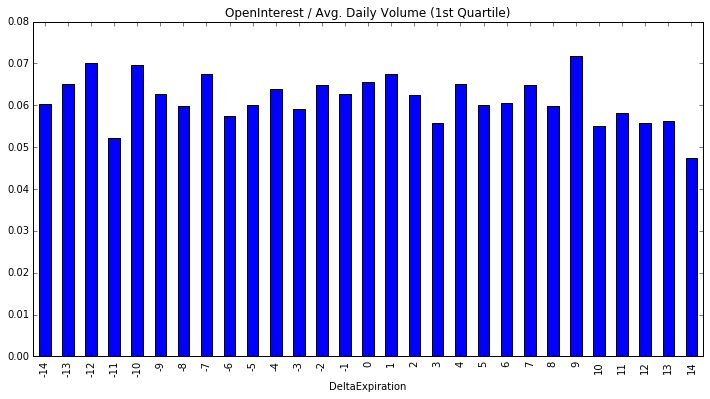

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

ppn_1.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')
plt.gcf().set_size_inches(12, 6)
plt.title('OpenInterest / Avg. Daily Volume (1st Quartile)');

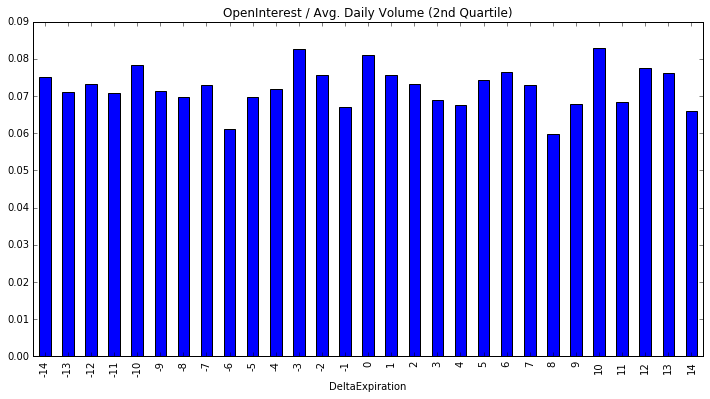

In [11]:
ppn_2.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')
plt.gcf().set_size_inches(12, 6)
plt.title('OpenInterest / Avg. Daily Volume (2nd Quartile)');

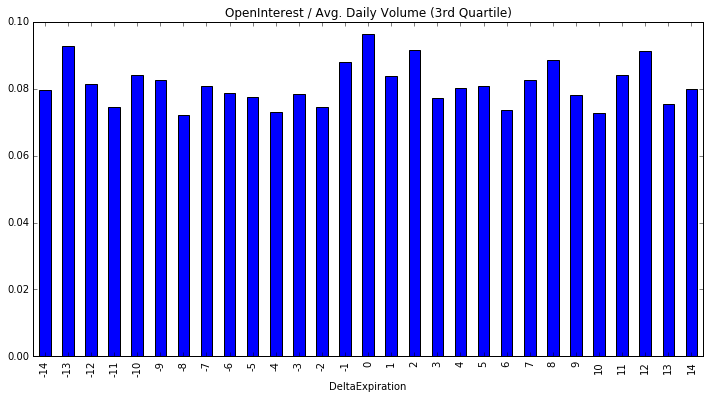

In [12]:
ppn_3.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')
plt.gcf().set_size_inches(12, 6)
plt.title('OpenInterest / Avg. Daily Volume (3rd Quartile)');

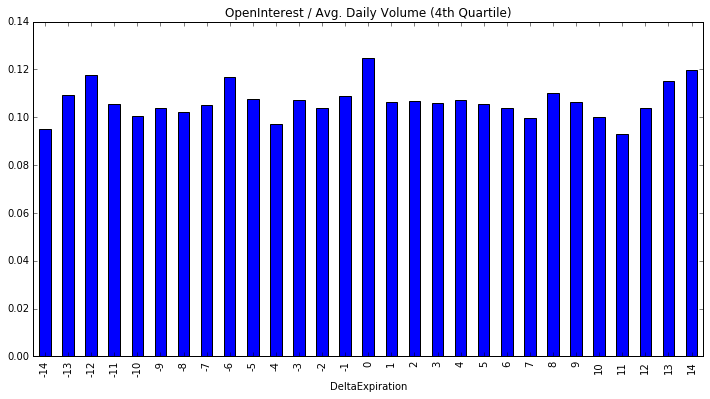

In [13]:
ppn_4.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')
plt.gcf().set_size_inches(12, 6)
plt.title('OpenInterest / Avg. Daily Volume (4th Quartile)');

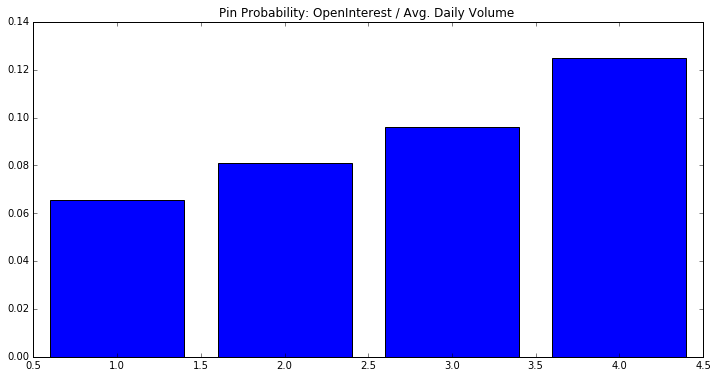

In [14]:
plt.bar(range(1, 5), [
        ppn_1[ppn_1['DeltaExpiration'] == 0].mean()['Pinned'],
        ppn_2[ppn_2['DeltaExpiration'] == 0].mean()['Pinned'],
        ppn_3[ppn_3['DeltaExpiration'] == 0].mean()['Pinned'],
        ppn_4[ppn_4['DeltaExpiration'] == 0].mean()['Pinned']
    ], align='center')
plt.gcf().set_size_inches(12, 6)
plt.title('Pin Probability: OpenInterest / Avg. Daily Volume ');

# Problem 2b.

We now repeat the same analysis, but will use a different binning criteria.

In [15]:
def score(group):
    group['Score2'] = group['OpenInterest'] / group[
        (group['DeltaExpiration'] >= 1) & (group['DeltaExpiration'] <= 5)
    ]['ClosePrice'].std() / group['ImpliedVolatility']
    return group

q2_atm_scored = q2_pinned.groupby(['Ticker', 'Expiration']).apply(score)

In [16]:
import numpy as np
bins = np.percentile(q2_atm_scored['Score2'].dropna(), [25, 50, 75])

In [17]:
ppn_1 = q2_atm_scored[q2_atm_scored['Score2'] <= bins[0]]
ppn_2 = q2_atm_scored[
    (q2_atm_scored['Score2'] > bins[0]) & (q2_atm_scored['Score2'] < bins[1])
]
ppn_3 = q2_atm_scored[
    (q2_atm_scored['Score2'] > bins[1]) & (q2_atm_scored['Score2'] < bins[2])
]
ppn_4 = q2_atm_scored[q2_atm_scored['Score2'] > bins[2]]

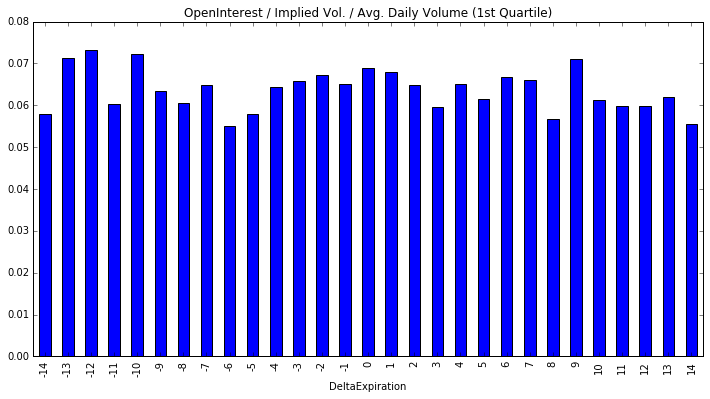

In [18]:
ppn_1.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')
plt.gcf().set_size_inches(12, 6)
plt.title('OpenInterest / Implied Vol. / Avg. Daily Volume (1st Quartile)');

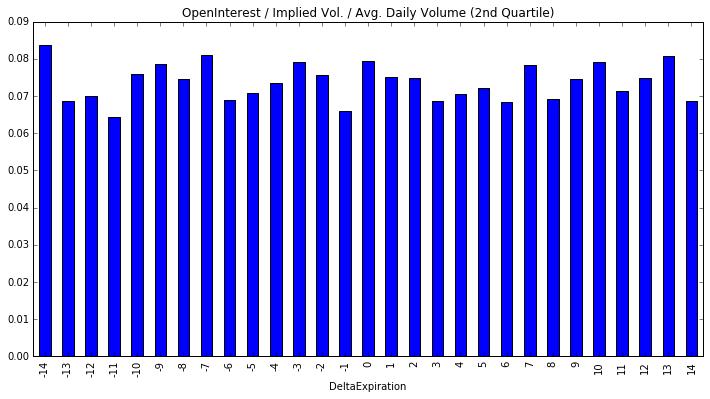

In [19]:
ppn_2.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')
plt.gcf().set_size_inches(12, 6)
plt.title('OpenInterest / Implied Vol. / Avg. Daily Volume (2nd Quartile)');

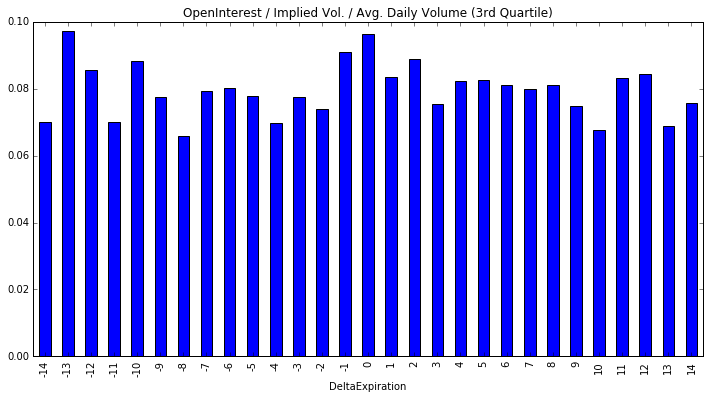

In [20]:
ppn_3.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')
plt.gcf().set_size_inches(12, 6)
plt.title('OpenInterest / Implied Vol. / Avg. Daily Volume (3rd Quartile)');

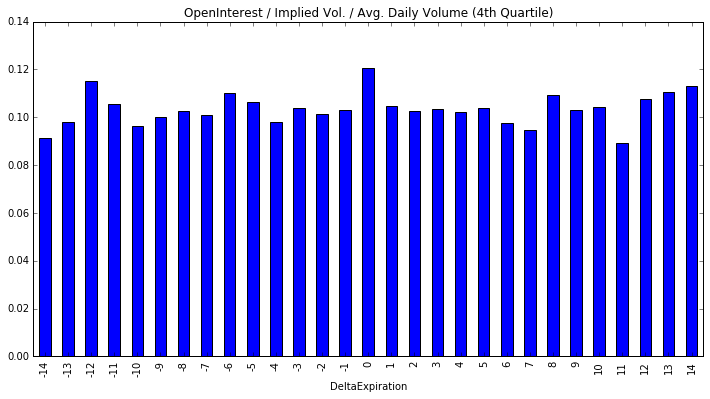

In [21]:
ppn_4.groupby(['DeltaExpiration']).mean()['Pinned'].plot(kind='bar', by='DeltaExpiration')
plt.gcf().set_size_inches(12, 6)
plt.title('OpenInterest / Implied Vol. / Avg. Daily Volume (4th Quartile)');

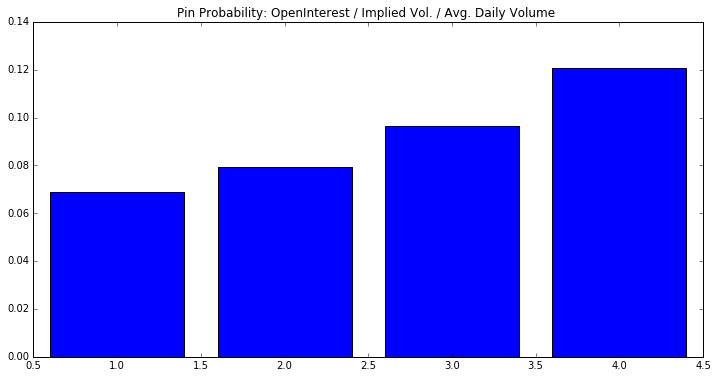

In [22]:
plt.bar(range(1, 5), [
        ppn_1[ppn_1['DeltaExpiration'] == 0].mean()['Pinned'],
        ppn_2[ppn_2['DeltaExpiration'] == 0].mean()['Pinned'],
        ppn_3[ppn_3['DeltaExpiration'] == 0].mean()['Pinned'],
        ppn_4[ppn_4['DeltaExpiration'] == 0].mean()['Pinned']
    ], align='center')
plt.gcf().set_size_inches(12, 6)
plt.title('Pin Probability: OpenInterest / Implied Vol. / Avg. Daily Volume ');

# Question 3

In [23]:
import math

def log_distance(group):
    day_preferences = [-5, -6, -4, -7]
    distances = [
        np.abs(group[group['DeltaExpiration'] == d]['ClosePrice'] -
               group[group['DeltaExpiration'] == d]['AdjStrike'])
        for d in day_preferences
    ]
    
    filt_distances = list(filter(lambda x: not x.empty, distances))
    if len(filt_distances) == 0:
        group['LogDistance'] = np.repeat(np.nan, len(group))
    else:
        try:
            group['LogDistance'] = np.repeat(math.log(filt_distances[0]), len(group))
        except ValueError:
            # Difference is 0
            group['LogDistance'] = np.repeat(-np.inf, len(group))
        except TypeError:
            group['LogDistance'] = np.repeat(np.log(filt_distances[0]).values[0], len(group))
                                         
    return group

q2_logdistance = q2_atm_scored.groupby(['Ticker', 'Expiration']).apply(log_distance)

In [24]:
logd_bins = np.percentile(q2_logdistance['LogDistance'].dropna(), [25, 50, 75])
logd_bins

array([-0.89158919, -0.12783433,  0.37156408])

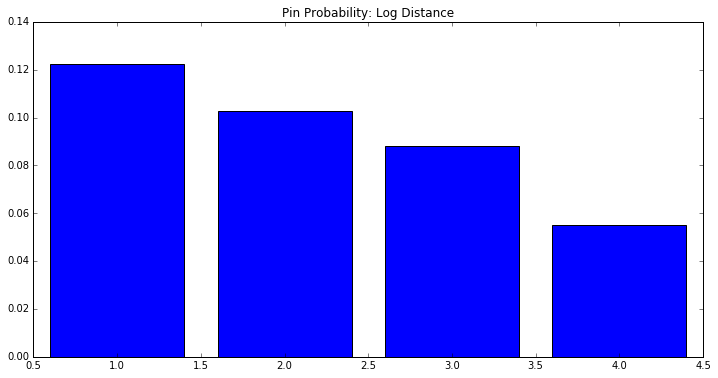

In [25]:
ppn_1 = q2_logdistance[q2_logdistance['LogDistance'] <= logd_bins[0]]
ppn_2 = q2_logdistance[
    (q2_logdistance['LogDistance'] > logd_bins[0]) & (q2_logdistance['LogDistance'] < logd_bins[1])
]
ppn_3 = q2_logdistance[
    (q2_logdistance['LogDistance'] > logd_bins[1]) & (q2_logdistance['LogDistance'] < logd_bins[2])
]
ppn_4 = q2_logdistance[q2_logdistance['LogDistance'] > logd_bins[2]]

plt.bar(range(1, 5), [
        ppn_1[ppn_1['DeltaExpiration'] == 0].mean()['Pinned'],
        ppn_2[ppn_2['DeltaExpiration'] == 0].mean()['Pinned'],
        ppn_3[ppn_3['DeltaExpiration'] == 0].mean()['Pinned'],
        ppn_4[ppn_4['DeltaExpiration'] == 0].mean()['Pinned'],
    ], align='center')
plt.gcf().set_size_inches(12, 6)
plt.title('Pin Probability: Log Distance');